In [73]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyRegressor

from scipy.stats.mstats import winsorize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [4]:
df = pd.read_csv(dataset)

### <a name='C2'> EDA et Choix des features   </a>

In [5]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

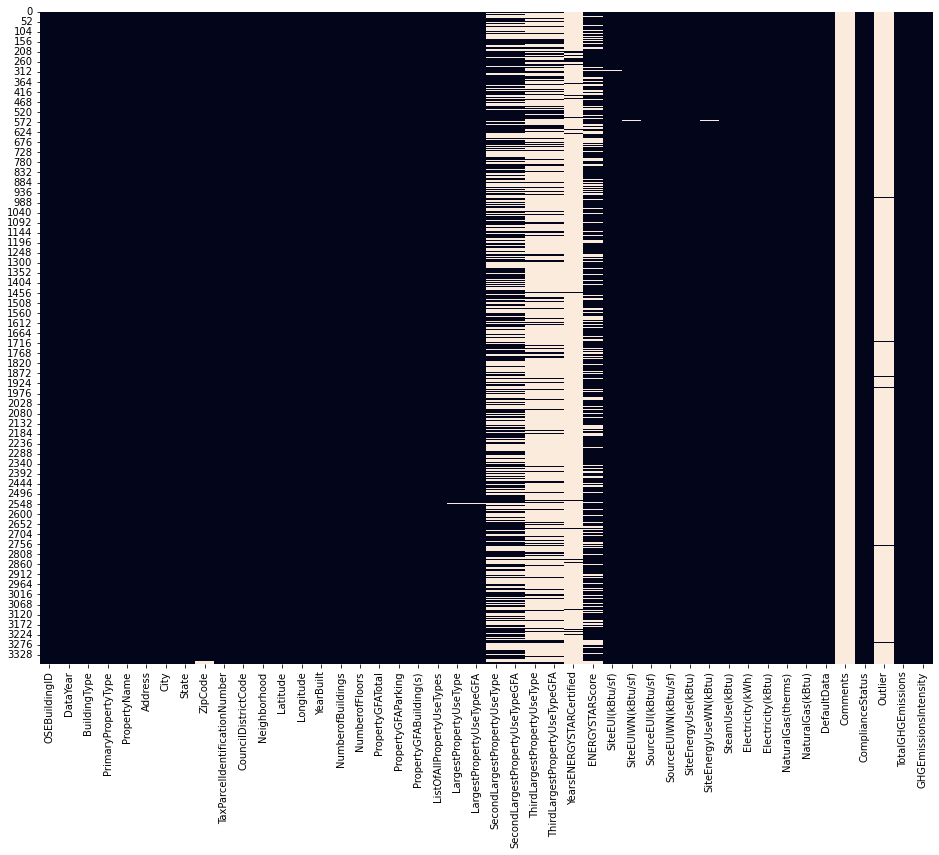

In [8]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

- Typologie des variables

In [9]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

- Nombre de variables différentes par Feature

In [10]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [11]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [12]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings résidentiels nous interressent dans le cadre de notre étude

In [13]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Ici ce sont les buildings de type Multifamily qui nous interressent (rajouter Campus??)

In [14]:
df.iloc[:,3].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

- Nombre de valeures nulles par feature

In [15]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


In [16]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA'] # Réflechir sur rajouter ou non Campus comme building résidentiel,'Campus','SPS-District K-12',

nonResidential = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

In [17]:
compliant = ['Compliant']

nonResidential = nonResidential[nonResidential['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [18]:
nonResidential.shape

(1432, 46)

In [19]:
nonResidential.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
Medical Office                  38
K-12 School                     38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

- Nettoyage et choix des features à utiliser

In [20]:
nonResidential = nonResidential.drop(nonResidential[nonResidential['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)

In [21]:
nonResidential = nonResidential.drop(nonResidential[nonResidential['PrimaryPropertyType'] == 'Residence Hall'].index)

In [22]:
nonResidential.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
K-12 School                     38
Medical Office                  38
Self-Storage Facility           28
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [23]:
nonResidential.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        633
SecondLargestPropertyUseTypeGFA     633


In [24]:
nonResidential['ComplianceStatus'].value_counts()

Compliant    1410
Name: ComplianceStatus, dtype: int64

In [25]:
nonResidential['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [26]:
nonResidential = nonResidential[nonResidential.Outlier.isnull()]

In [27]:
nonResidential = nonResidential[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions']]

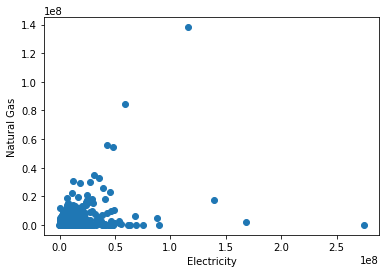

In [28]:
plt.scatter(nonResidential['Electricity(kBtu)'],nonResidential['NaturalGas(kBtu)'])
plt.xlabel('Electricity')
plt.ylabel('Natural Gas')
plt.show()

In [29]:
nonResidential.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    4
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
dtype: int64

In [30]:
nonResidential = nonResidential.dropna(axis=0) 

In [31]:
nonResidential['NumberofBuildings'].value_counts()

1.0    1329
0.0      44
2.0      11
3.0      10
6.0       4
5.0       3
4.0       2
9.0       1
7.0       1
8.0       1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [32]:
df1 = nonResidential.copy()

In [33]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [34]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [35]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [36]:
df2_code = pd.get_dummies(df1 ,columns=['PrimaryPropertyType','YearBuilt'])

In [37]:
train, test = train_test_split(df2_code, test_size=0.2) 

In [38]:
X_train, y_train, X_test, y_test = train.drop(columns = "TotalGHGEmissions"), train["TotalGHGEmissions"],test.drop(columns = "TotalGHGEmissions") ,test["TotalGHGEmissions"]

In [39]:
r_forest = RandomForestRegressor(random_state=0)

In [40]:
# entrainement du modèle
r_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [41]:
# prédiction
preds = r_forest.predict(X_test)

# calcul du RMSE
print(m_s_e(y_test,preds, squared=False))

308.6329244278285


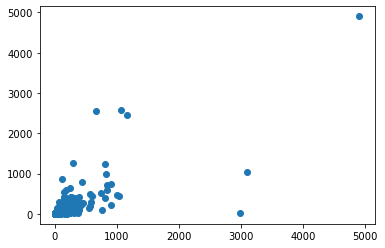

In [42]:
plt.scatter(preds,y_test)

In [43]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [44]:
def get_dummy_error(strategy, X_train, X_test, y_train, y_test):
    model = DummyRegressor(strategy=strategy)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [45]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for strategy in ['mean', 'median']:
    my_rmse = get_dummy_error(strategy, X_train, X_test, y_train, y_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("strategy: %s  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(strategy, my_rmse[0], my_rmse[1], my_rmse[2]))

strategy: mean  		 RMSE:  421.254123  		 MAE: 189.255503  		 R2:  -0.000114
strategy: median  		 RMSE:  437.850325  		 MAE: 144.400709  		 R2:  -0.080469


In [46]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X_train, X_test, y_train, y_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  308.632924  		 MAE: 112.915717  		 R2:  0.463159
N_Estimator: 200  		 RMSE:  310.665660  		 MAE: 111.945280  		 R2:  0.456064
N_Estimator: 300  		 RMSE:  305.739131  		 MAE: 110.966469  		 R2:  0.473179
N_Estimator: 400  		 RMSE:  300.791595  		 MAE: 109.885417  		 R2:  0.490091
N_Estimator: 500  		 RMSE:  304.574616  		 MAE: 110.124041  		 R2:  0.477184


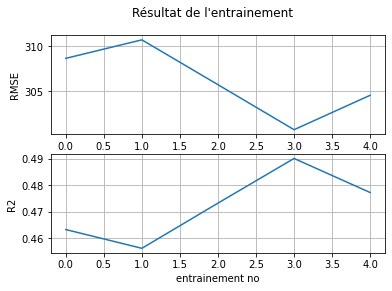

In [47]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

In [60]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [61]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 6,scoring='r2')
CV_dummy_mean.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, scoring='r2')

In [62]:
CV_dummy_mean.best_score_

-0.011509436372381035

In [63]:
dummy_model = CV_dummy_mean.best_estimator_

In [64]:
dummy_model.score(X_test,y_test)

-0.00011370903596374937

In [72]:
pd.DataFrame(CV_dummy_mean.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001163,0.000372,0.000166,0.000372,mean,{'strategy': 'mean'},-0.004951,-0.012480,-0.00396,-0.000823,-0.014230,-0.032613,-0.011509,0.010551,1
1,0.000825,0.000369,0.000332,0.000470,median,{'strategy': 'median'},-0.033720,-0.125541,-0.03394,-0.045939,-0.081105,-0.116676,-0.072820,0.037715,2


In [70]:
rfc_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],}

In [71]:
CV_rfc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 6,scoring='r2')
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='r2')

In [67]:
CV_rfc.best_params_

{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 100}

In [68]:
CV_rfc.best_score_

0.5235600535396105

In [69]:
model = CV_rfc.best_estimator_

In [58]:
model.score(X_test,y_test)

0.6108079433845011

In [59]:
pd.DataFrame(CV_rfc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.098489,0.002502,0.004736,0.000390,4,auto,50,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.620905,-2.095932,0.755559,0.712685,0.238730,0.355267,0.097869,0.998581,30
1,0.194446,0.002974,0.008257,0.000539,4,auto,100,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.634824,-1.683152,0.754090,0.714820,0.258245,0.298817,0.162941,0.847772,28
2,0.051002,0.001010,0.004902,0.000403,4,sqrt,50,"{'max_depth': 4, 'max_features': 'sqrt', 'n_es...",0.441468,0.263950,0.625232,0.533539,0.203114,0.360158,0.404577,0.146638,20
3,0.098417,0.001042,0.008067,0.000063,4,sqrt,100,"{'max_depth': 4, 'max_features': 'sqrt', 'n_es...",0.525761,0.436147,0.710504,0.606638,0.200209,0.351474,0.471789,0.167125,11
4,0.050136,0.000870,0.004728,0.000514,4,log2,50,"{'max_depth': 4, 'max_features': 'log2', 'n_es...",0.369406,0.305371,0.769097,0.534545,0.192625,0.364643,0.422614,0.185028,19
5,0.098974,0.001584,0.007898,0.000290,4,log2,100,"{'max_depth': 4, 'max_features': 'log2', 'n_es...",0.564017,0.326614,0.691946,0.647126,0.190384,0.397980,0.469678,0.179538,13
6,0.110737,0.001167,0.005120,0.000208,5,auto,50,"{'max_depth': 5, 'max_features': 'auto', 'n_es...",0.637704,-1.891132,0.728762,0.754931,0.268167,0.308879,0.134552,0.925811,29
7,0.220860,0.002455,0.008743,0.000566,5,auto,100,"{'max_depth': 5, 'max_features': 'auto', 'n_es...",0.649553,-1.697242,0.707298,0.701897,0.297181,0.469820,0.188084,0.855596,26
8,0.053522,0.000647,0.004839,0.000472,5,sqrt,50,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.564298,0.388545,0.739524,0.519416,0.241060,0.368738,0.470263,0.159833,12
9,0.105490,0.002306,0.008364,0.001475,5,sqrt,100,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.559084,0.293008,0.775311,0.577023,0.247629,0.419243,0.478550,0.180517,10


- Ridge Regression

In [93]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
              }

In [94]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 6,scoring='r2')
CV_ridge.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]},
             scoring='r2')

In [95]:
CV_ridge.best_score_

0.2667340884335481

In [96]:
model_ridge = CV_ridge.best_estimator_

In [97]:
model_ridge.score(X_test,y_test)

0.45936658436571587

In [98]:
pd.DataFrame(CV_ridge.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006657,0.005079,0.001995,0.000576,0.001,{'alpha': 0.001},0.839682,-3.218021,0.784931,0.753071,0.379671,-0.051396,-0.085344,1.434518,7
1,0.002991,0.000575,0.001829,0.000686,0.01,{'alpha': 0.01},0.839390,-3.183219,0.784830,0.752614,0.379720,-0.053659,-0.080054,1.421763,6
2,0.002577,0.000448,0.001330,0.000470,0.1,{'alpha': 0.1},0.836526,-2.861081,0.783812,0.747966,0.379984,-0.076233,-0.031504,1.304072,5
3,0.002264,0.000397,0.001649,0.000439,1,{'alpha': 1},0.812500,-1.147831,0.773576,0.700307,0.374966,-0.283346,0.205029,0.711242,3
4,0.002725,0.000370,0.001351,0.000458,2,{'alpha': 2},0.793165,-0.512518,0.763495,0.654160,0.366359,-0.464256,0.266734,0.551589,1
5,0.002159,0.000358,0.001034,0.000030,5,{'alpha': 5},0.758683,-0.103138,0.742583,0.563381,0.345427,-0.793287,0.252275,0.551034,2
6,0.002156,0.000341,0.001494,0.000485,10,{'alpha': 10},0.731159,-0.080562,0.724019,0.490560,0.325625,-1.029747,0.193509,0.612055,4
